In [145]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [146]:
import numpy as np
import pandas as pd

In [147]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [148]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

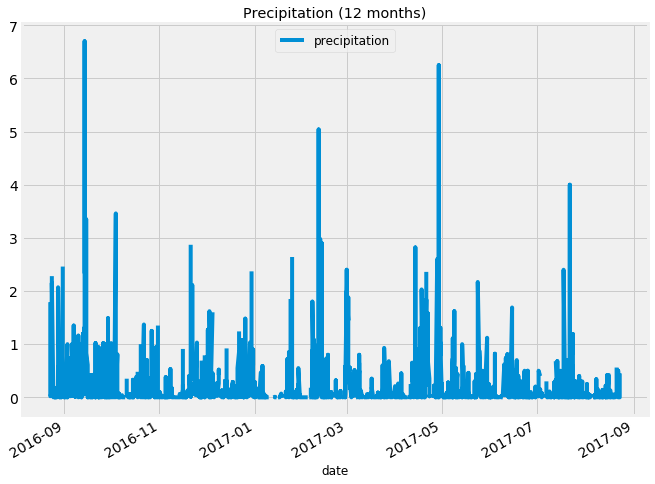

In [113]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
max_date = max_date[0]

# Calculate the date 1 year ago from the last data point in the database
#past_12m = dt.date(dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores

query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
#max_date
precipitation_df.plot(title="Precipitation (12 months)",figsize=(10,8), fontsize=14)
plt.legend(loc='upper center', fontsize=12)
plt.savefig("Precipitation.png")
plt.show()




In [114]:
year_ago

datetime.datetime(2016, 8, 22, 0, 0)

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_available=session.query(Measurement.station).distinct().count()
#print(station_available)
print(station_available)

9


In [81]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#active_stations=session.query(Measurement.station, func.count(Measurement.station))
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station


('USC00519281', 2772)

In [98]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

tempmax_active_station = session.query(Measurement.tobs, func.max(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.max(Measurement.tobs).desc()).all()
print('Max Temperature:',tempmax_active_station[0][0])  

Max Temperature: 87.0


In [83]:
tempmin_active_station = session.query(Measurement.tobs, func.min(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.min(Measurement.tobs).asc()).all()
print('Min Temperature:',tempmin_active_station[0][0])  

Min Temperature: 53.0


In [84]:
tempavg_active_station = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.avg(Measurement.tobs).asc()).all()
print('avg Temperature:',tempavg_active_station[0][0])

avg Temperature: 73.0


In [88]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#year_ago
best_station = active_station[0][0]
temp_results = session.query(Measurement.station, Measurement.tobs).\
                  filter(Measurement.station == best_station).\
                  filter(Measurement.date >= year_ago).all()
tobs_df = pd.DataFrame(temp_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

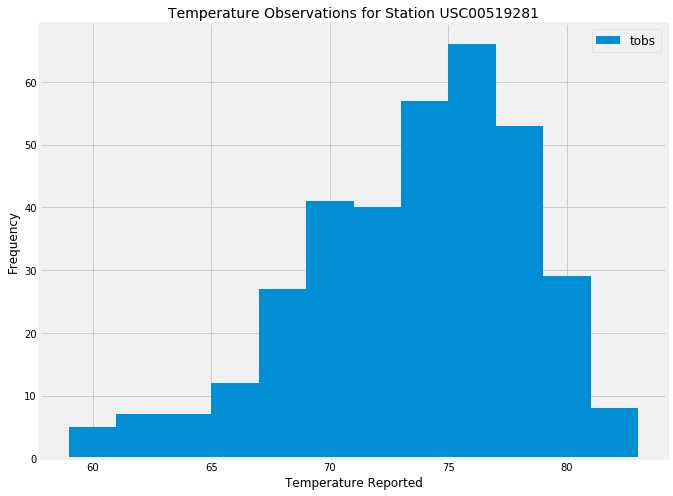

In [107]:
tobs_df.plot.hist(by='station', bins=12, figsize=(10,8))

plt.title("Temperature Observations for Station " + best_station, fontsize=14)
plt.xlabel("Temperature Reported", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), fontsize=12)
plt.grid(True)
plt.savefig("StationTemperature.png")
plt.show

![precipitation](Images/station-histogram.png)

In [106]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


In [137]:
trip_res=calc_temps('2017-04-14', '2017-04-20')
print(calc_temps('2017-04-14', '2017-04-20'))

[(67.0, 73.0, 83.0)]


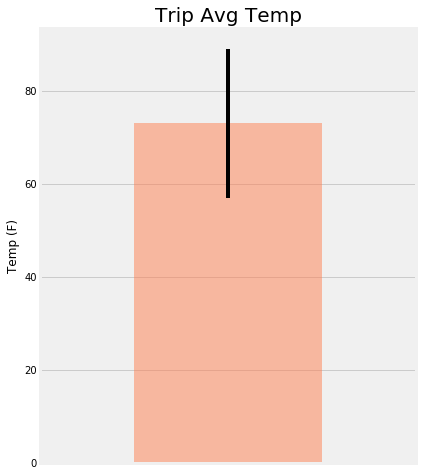

In [141]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_res, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(True)
plt.savefig("Temp_trip.png")
plt.show()


In [167]:
#rain_per_station = session.query(Measurement.station, Measurement.name, Measurement.latitude, Measurement.longitude, Measurement.elevation,func.sum(Measurement.prcp)).\
#group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
#rain_per_station
measur_data_to_load = "Resources/hawaii_measurements.csv"
stations_data_to_load = "Resources/hawaii_stations.csv"

measur_data_read=pd.read_csv(measur_data_to_load)
stations_data_read=pd.read_csv(stations_data_to_load)
#city_data_read.head()

hawaii_data_merge=pd.merge(measur_data_read,stations_data_read, on="station", how = "left")

hawaii_data_merge.head()


,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00519397,2010-01-01,0.08,65,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [179]:
hawaii_data_rain=hawaii_data_merge.groupby('station')['prcp'].sum()
hawaii_data_date=hawaii_data_merge.groupby('name')['latitude','longitude', 'elevation']
hawaii_data_rain
#hawaii_data_concat=pd.concat(hawaii_data_rain,hawaii_data_date)

station
USC00511918      92.68
USC00513117     382.62
USC00514830     234.49
USC00516128    1068.09
USC00517948      43.44
USC00518838      70.87
USC00519281     588.64
USC00519397     131.62
USC00519523     295.68
Name: prcp, dtype: float64

In [ ]:
test = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.avg(Measurement.tobs).asc()).all()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station,name,latitude,longitude,elevation

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


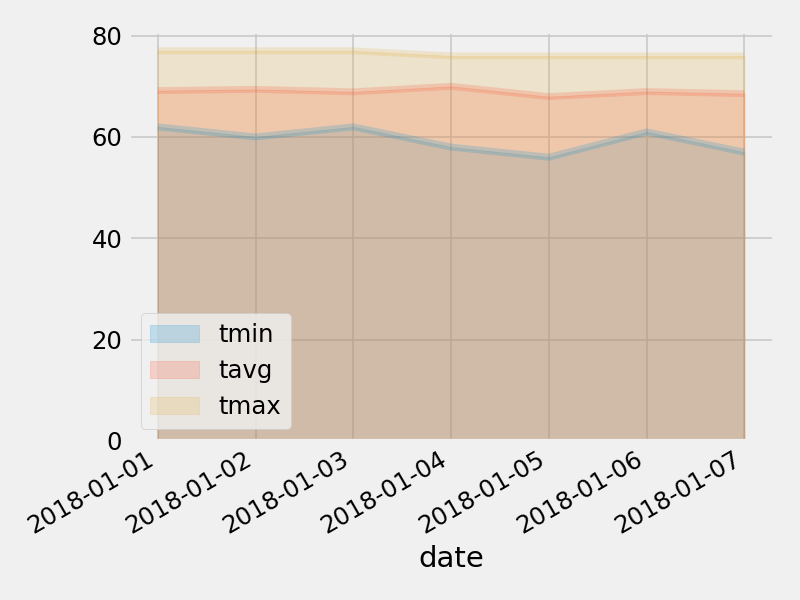

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
